# Initial Explaratory Data Analysis

## Import Libraries

In [1]:
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import ngrams
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

## Import Data

In [2]:
data = pd.read_csv('Data/RawData.csv')
data

,text,label
0,"Hallo semuaaa, mau nanyaa ya..\r\nBunda bunda ...",0
1,"Saya mau tanya , ketika saya di caci maki oleh...",0
2,"Kasih semangat buat aku ya bund,,di usiaku yg ...",0
3,Masih belom bisa ngatur uang 50 ribu buat seha...,0
4,"Mohon ijin, saya mau curhat. Saya seorang istr...",2
...,...,...
3198,pagi bunda bunda .. pngn cerita nu\r\nmnrt bun...,2
3199,assalamualaikum Bun ...izin bertanya Bun .saya...,0
3200,Bun sepertinya aku dianggap sombong sama orang...,0
3201,HARAP HORMATI CURHATAN YANG MASUK KE GRUP INI....,0


## Missing Values

In [3]:
data.isna().sum()

text     0
label    0
dtype: int64

## Duplicates

In [4]:
data.duplicated().sum()

np.int64(1040)

## Example Text

In [5]:
data['text'].values[0]

'Hallo semuaaa, mau nanyaa ya..\r\nBunda bunda jika dihadapkan dengan 2 pilihan, pilih yang mana?\r\n1. Penghasilan 50jt/bulan (LDM Jabar-kalimantan) bisnis batubara dan kebun sawit, tp jarang ketemu karena ngontrol bisnis\r\n2. Usaha di Jabar (sawah) penghasilan tidak sebesar seperti nomer 1, tp serumah\r\nKalian pilih yg mana? Dan berikan alasannya 🙏🏻'

## Emoji on Text

In [6]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons 😀😅😂🤣😇🙃🙂
    "\U0001F300-\U0001F5FF"  # symbols & pictographs 🌍🌈⛄
    "\U0001F680-\U0001F6FF"  # transport & map symbols 🚀🚗🛳️
    "\U0001F1E0-\U0001F1FF"  # flags 🇮🇩🇺🇸
    "\U00002702-\U000027B0"  # dingbats ✂️✈️✔️
    "\U000024C2-\U0001F251"  # enclosed characters 🅰️🆗
    "]+",
    flags=re.UNICODE,
)

has_emoji = data["text"].astype(str).apply(lambda x: bool(emoji_pattern.search(x)))

print("Number of reviews containing emoji:", has_emoji.sum())
print("Percentage of reviews with emoji:", round(has_emoji.mean() * 100, 2), "%")

Number of reviews containing emoji: 890
Percentage of reviews with emoji: 27.79 %


## Wordcloud

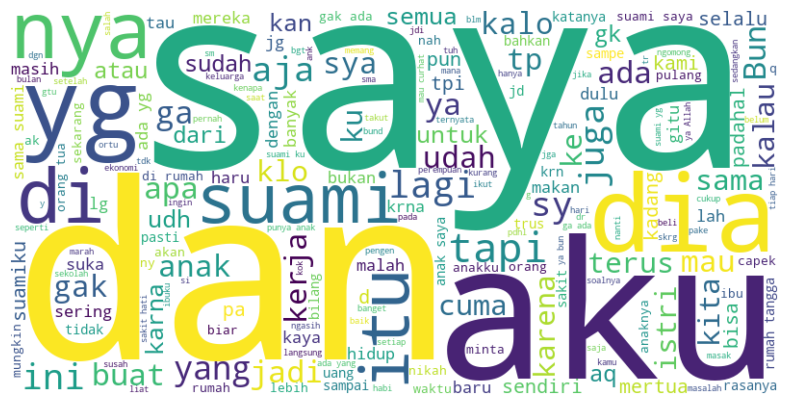

In [7]:
text = ' '.join(data['text'].astype(str).tolist())
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

## Check Score Distribution

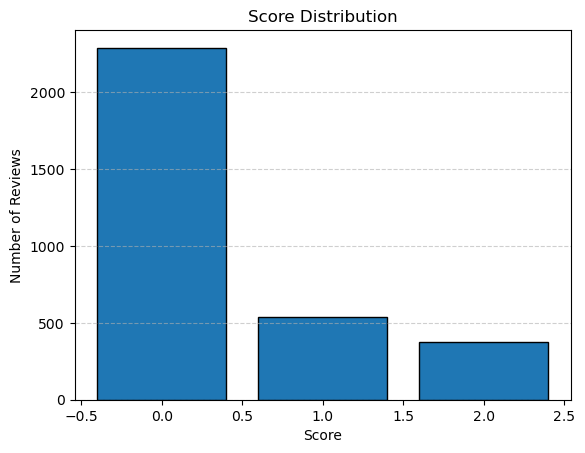

In [8]:
score_count = data["label"].value_counts().sort_index()
plt.bar(
    score_count.index,
    score_count.values,
    edgecolor="black"
)
plt.title(f"Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.grid(axis="y", linestyle="--", alpha=0.6)

## Check Length and Word Count by Score

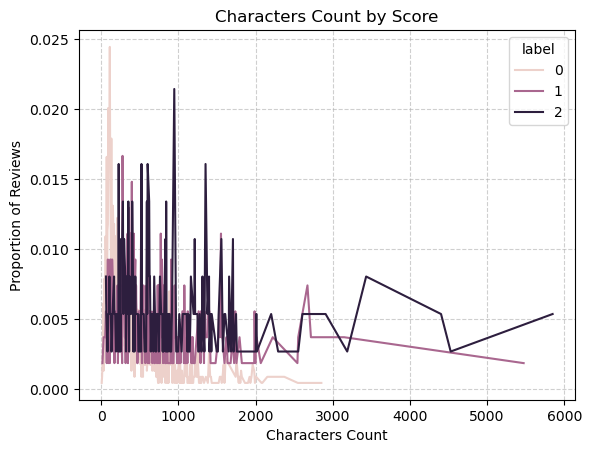

In [9]:
data["length"] = data["text"].astype(str).apply(len)
bins = np.arange(0, data["length"].max() + 5, 5)
data["word_bin"] = pd.cut(data["length"], bins)

counts = (
    data.groupby(["word_bin", "label"], observed=True)
    .size().reset_index(name="count")
)
total_per_score = counts.groupby("label")["count"].transform("sum")
counts["normalized"] = counts["count"] / total_per_score
counts["word_mid"] = counts["word_bin"].apply(lambda x: x.mid)

sns.lineplot(data=counts, x="word_mid", y="normalized", hue="label")
plt.title(f"Characters Count by Score")
plt.xlabel("Characters Count")
plt.ylabel("Proportion of Reviews")
plt.grid(True, linestyle="--", alpha=0.6)

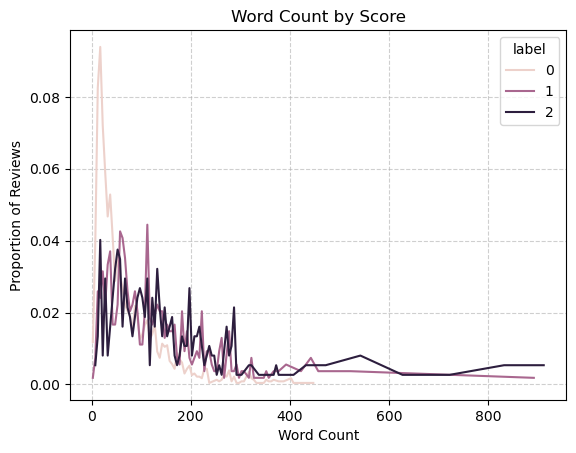

In [10]:
data["word_count"] = data["text"].astype(str).str.split().apply(len)
bins = np.arange(0, data["word_count"].max() + 5, 5)
data["word_bin"] = pd.cut(data["word_count"], bins)

counts = (
    data.groupby(["word_bin", "label"], observed=True)
    .size().reset_index(name="count")
)
total_per_score = counts.groupby("label")["count"].transform("sum")
counts["normalized"] = counts["count"] / total_per_score
counts["word_mid"] = counts["word_bin"].apply(lambda x: x.mid)

sns.lineplot(data=counts, x="word_mid", y="normalized", hue="label")
plt.title(f"Word Count by Score")
plt.xlabel("Word Count")
plt.ylabel("Proportion of Reviews")
plt.grid(True, linestyle="--", alpha=0.6)

## Ngrams by Score

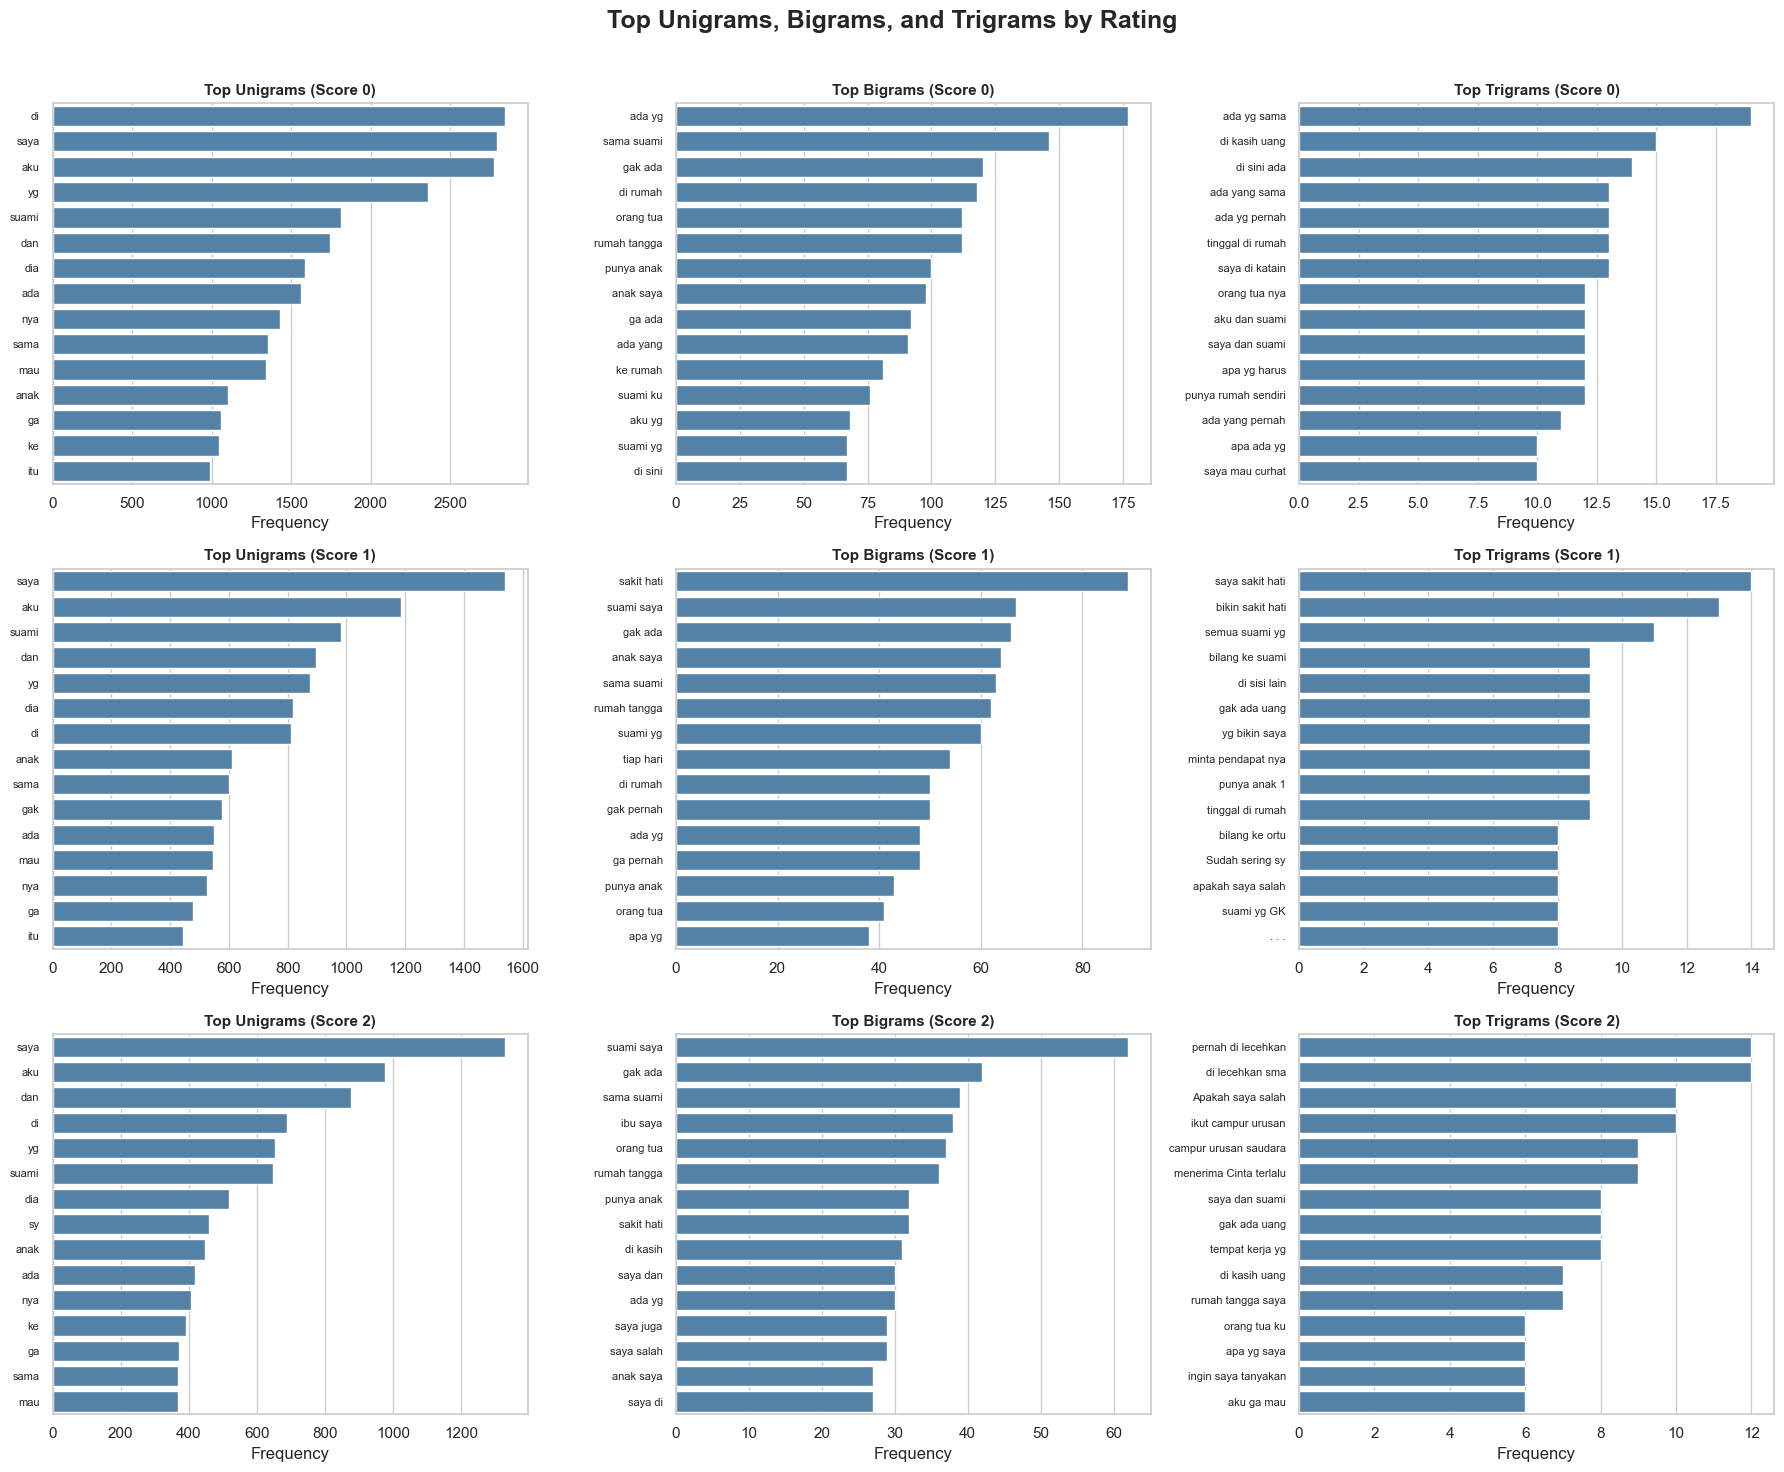

In [11]:
# --- Setup ---
sns.set(style="whitegrid")

# ensure 'score' column is numeric
data["label"] = pd.to_numeric(data["label"], errors="coerce")

# get sorted unique ratings (e.g. [1,2,3,4,5])
ratings = sorted(data["label"].dropna().unique())
n_scores = len(ratings)

# create subplot grid: one row per rating, 3 columns for unigram/bigram/trigram
fig, axes = plt.subplots(n_scores, 3, figsize=(18, 5 * n_scores))
if n_scores == 1:
    axes = [axes]  # handle case with only one rating

# --- Generate n-grams and plots per rating ---
for row, score in enumerate(ratings):
    df_subset = data[data["label"] == score]
    words = " ".join(df_subset["text"].dropna()).split()

    # store results for each n
    ngram_dfs = []

    for n, label in zip([1, 2, 3], ["Unigram", "Bigram", "Trigram"]):
        ngram_counts = Counter(ngrams(words, n))
        top_ngrams = ngram_counts.most_common(15)
        df_ngram = pd.DataFrame(top_ngrams, columns=["ngram", "count"])
        df_ngram["ngram"] = df_ngram["ngram"].apply(lambda x: " ".join(x))
        df_ngram["type"] = label
        ngram_dfs.append(df_ngram)

    ngram_df = pd.concat(ngram_dfs, ignore_index=True)

    # plot each n-gram type in separate column
    for col, label in enumerate(["Unigram", "Bigram", "Trigram"]):
        ax = axes[row][col] if n_scores > 1 else axes[col]
        subset = ngram_df[ngram_df["type"] == label].sort_values("count", ascending=False)

        sns.barplot(y="ngram", x="count", data=subset, ax=ax, color="steelblue")
        ax.set_title(f"Top {label}s (Score {score})", fontsize=11, fontweight="bold")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("")
        ax.tick_params(axis='y', labelsize=8)

plt.suptitle("Top Unigrams, Bigrams, and Trigrams by Rating", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
